# PAINTINGS AI

In [3]:
# Carga librerías
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt

In [4]:
# Transformaciones
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Dataset personalizado
class ArtDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.authors = sorted(self.data['artist'].unique())
        self.styles = sorted(self.data['style'].unique())
        self.author_to_idx = {author: idx for idx, author in enumerate(self.authors)}
        self.style_to_idx = {style: idx for idx, style in enumerate(self.styles)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['path'].replace('\\', '/')
        full_path = os.path.join(self.img_dir, os.path.basename(img_path))
        image = Image.open(full_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        author = self.author_to_idx[self.data.iloc[idx]['artist']]
        style = self.style_to_idx[self.data.iloc[idx]['style']]
        return image, author, style

In [ ]:
# Cargar datos
# Obtener la ruta absoluta del directorio donde está el script .py
script_dir = os.path.dirname(os.path.abspath("1001_images"))

# Ruta a la carpeta de imágenes que está en el mismo lugar que el script
img_dir = os.path.join(script_dir, "1001_images")
csv_path = "https://raw.githubusercontent.com/jsantonjag/PaintingsAI/refs/heads/main/data/dataset_completo.csv"

df = pd.read_csv(csv_path)
df['path'] = df['path'].apply(lambda x: os.path.join(img_dir, x))

full_dataset = ArtDataset(csv_file=csv_path, img_dir=img_dir, transform=transform)

# Dividir en train/test pequeño
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

## ResNet18 (ReLu, BatchNorm, Dropout, Optimizer-Adam, Scheduler)

In [ ]:
# Modelo multitarea configurable
class MultiTaskResNet(nn.Module):
    def __init__(self, num_authors, num_styles, BATCHNORM, ACTIVATION_FN, DROPOUT, DROPOUT_PROB, LINK_FN, loss_function):
        super(MultiTaskResNet, self).__init__()
        
        self.loss_FN = loss_function
        self.link_FN = LINK_FN
        self.activation_FN = ACTIVATION_FN
        self.batchNorm = BATCHNORM
        self.dropout = DROPOUT
        self.dropout_prob = DROPOUT_PROB
        
        base_model = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.features = nn.Sequential(*list(base_model.children())[:-1])
        in_features = base_model.fc.in_features

        layers = [nn.Flatten()]
        if self.batchNorm:
            layers.append(nn.BatchNorm1d(in_features))
            
        layers.append(self.wrap_activation(self.activation_FN))
        
        if self.dropout:
            layers.append(nn.Dropout(self.dropout_prob))
        
        layers.append(nn.Linear(in_features, in_features))
        self.shared_head = nn.Sequential(*layers)
        self.fc_artist = nn.Linear(in_features, num_authors)
        self.fc_style = nn.Linear(in_features, num_styles)

    def wrap_activation(self, ACTIVATION_FN):
        if ACTIVATION_FN == torch.relu:
            return nn.ReLU()
        elif ACTIVATION_FN == torch.tanh:
            return nn.Tanh()
        else:
            raise ValueError("Función de activación no soportada. Usa torch.relu o torch.tanh.")


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.shared_head(x)
        artist_output = self.link_FN(self.fc_artist(x), dim=1)
        style_output = self.link_FN(self.fc_style(x), dim=1)
        return artist_output, style_output
    
    def compute_loss(self, artist_logits, artist_targets, style_logits, style_targets):
        return self.loss_FN(artist_logits, artist_targets) + self.loss_FN(style_logits, style_targets)
    
    
def test_model(model, epochs, train_loader, test_loader, device):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loss_list, train_acc_artist_list, test_acc_artist_list = [], [], []
    train_acc_style_list, test_acc_style_list = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_artist, correct_style, total = 0, 0, 0

        for images, artist_labels, style_labels in train_loader:
            images, artist_labels, style_labels = images.to(device), artist_labels.to(device), style_labels.to(device)
            optimizer.zero_grad()
            artist_logits, style_logits = model(images)
            loss = model.compute_loss(artist_logits, artist_labels, style_logits, style_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            with torch.no_grad():
                artist_preds = torch.argmax(artist_logits, dim=1)
                style_preds = torch.argmax(style_logits, dim=1)
                correct_artist += (artist_preds == artist_labels).sum().item()
                correct_style += (style_preds == style_labels).sum().item()
                total += images.size(0)

        train_loss_list.append(total_loss / len(train_loader))
        train_acc_artist_list.append(correct_artist / total)
        train_acc_style_list.append(correct_style / total)

        # Evaluación en test
        model.eval()
        correct_artist_test, correct_style_test, total_test = 0, 0, 0
        with torch.no_grad():
            for images, artist_labels, style_labels in test_loader:
                images, artist_labels, style_labels = images.to(device), artist_labels.to(device), style_labels.to(device)
                artist_logits, style_logits = model(images)
                artist_preds = torch.argmax(artist_logits, dim=1)
                style_preds = torch.argmax(style_logits, dim=1)
                correct_artist_test += (artist_preds == artist_labels).sum().item()
                correct_style_test += (style_preds == style_labels).sum().item()
                total_test += images.size(0)

        test_acc_artist_list.append(correct_artist_test / total_test)
        test_acc_style_list.append(correct_style_test / total_test)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_loader):.4f} - Train Acc Artist: {correct_artist / total:.2%} - Train Acc Style: {correct_style / total:.2%}")

    return train_loss_list, train_acc_artist_list, test_acc_artist_list, train_acc_style_list, test_acc_style_list

    

### Comparing activation functions (ReLU VS Tahn)

In [ ]:
# ReLU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiTaskResNet(
    num_authors=len(full_dataset.authors), 
    num_styles=len(full_dataset.styles),
    BATCHNORM = True, 
    ACTIVATION_FN = torch.relu, 
    DROPOUT = True, 
    DROPOUT_PROB = 0.3, 
    LINK_FN = torch.softmax, 
    loss_function = nn.CrossEntropyLoss(),
)

losses, train_artist_acc, test_artist_acc, train_style_acc, test_style_acc = test_model(
    model=model,
    epochs=10,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device
)

NameError: name 'MultiTaskResNet' is not defined

In [ ]:
# Tahn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiTaskResNet(
    num_authors=len(full_dataset.authors), 
    num_styles=len(full_dataset.styles),
    BATCHNORM = True, 
    ACTIVATION_FN = torch.tanh, 
    DROPOUT = True, 
    DROPOUT_PROB = 0.3, 
    LINK_FN = torch.softmax, 
    loss_function = nn.CrossEntropyLoss(),
)

losses_tahn, train_artist_acc_tahn, test_artist_acc_tahn, train_style_acc_tahn, test_style_acc_tahn = test_model(
    model=model,
    epochs=10,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device
)

Epoch 1/10 - Loss: 9.2144 - Train Acc Artist: 1.00% - Train Acc Style: 14.75%
Epoch 2/10 - Loss: 9.1591 - Train Acc Artist: 2.62% - Train Acc Style: 17.75%
Epoch 3/10 - Loss: 9.1633 - Train Acc Artist: 2.38% - Train Acc Style: 17.50%
Epoch 4/10 - Loss: 9.1244 - Train Acc Artist: 2.88% - Train Acc Style: 20.75%
Epoch 5/10 - Loss: 9.1149 - Train Acc Artist: 2.88% - Train Acc Style: 21.75%
Epoch 6/10 - Loss: 9.1388 - Train Acc Artist: 2.75% - Train Acc Style: 19.38%
Epoch 7/10 - Loss: 9.1361 - Train Acc Artist: 2.75% - Train Acc Style: 19.88%
Epoch 8/10 - Loss: 9.1769 - Train Acc Artist: 2.12% - Train Acc Style: 16.25%
Epoch 9/10 - Loss: 9.1547 - Train Acc Artist: 2.50% - Train Acc Style: 18.12%
Epoch 10/10 - Loss: 9.1702 - Train Acc Artist: 1.50% - Train Acc Style: 17.62%


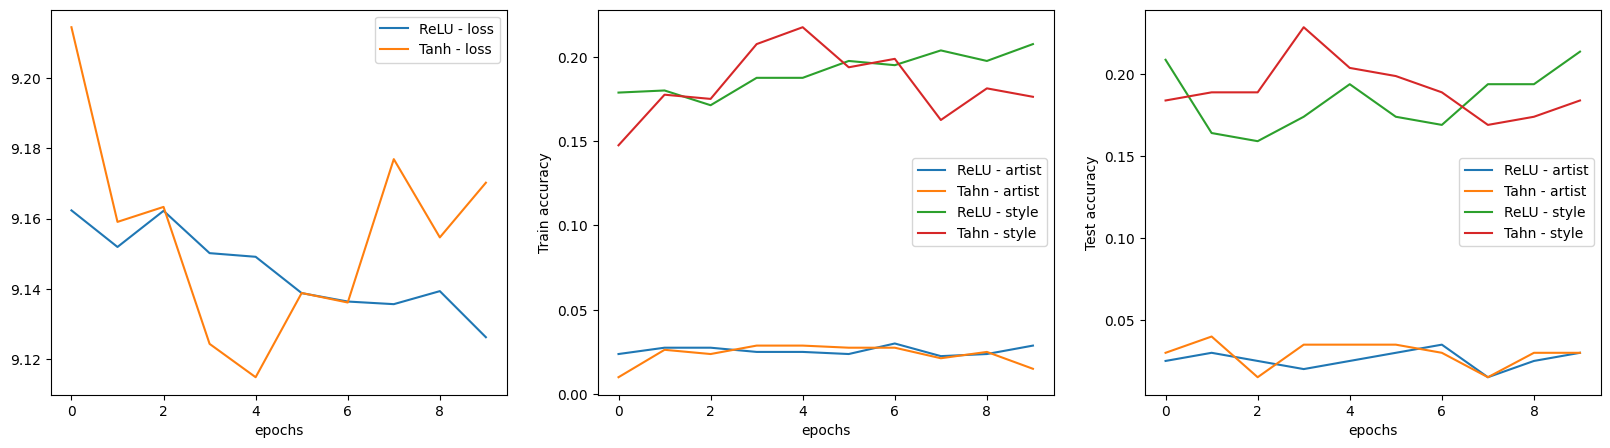

In [ ]:
fig, (ax11,ax21,ax31) = plt.subplots(1,3, figsize = (20,5))


## Plot cross entropy loss
ax11.plot(range(len(losses)), losses, label = 'ReLU - loss', color = 'C0')
ax11.plot(range(len(losses_tahn)), losses_tahn, label = 'Tanh - loss', color = 'C1')
ax11.set_xlabel('epochs')
ax11.legend()

## Plot train acc
ax21.plot(range(len(train_artist_acc)), train_artist_acc, label = 'ReLU - artist', color = 'C0')
ax21.plot(range(len(train_artist_acc_tahn)), train_artist_acc_tahn, label = 'Tahn - artist', color = 'C1')
ax21.plot(range(len(train_style_acc)), train_style_acc, label = 'ReLU - style', color = 'C2')
ax21.plot(range(len(train_style_acc_tahn)), train_style_acc_tahn, label = 'Tahn - style', color = 'C3')
ax21.set_ylabel('Train accuracy')
ax21.set_xlabel('epochs')
ax21.legend()

## Plot test acc
ax31.plot(range(len(test_artist_acc)), test_artist_acc, label = 'ReLU - artist', color = 'C0')
ax31.plot(range(len(test_artist_acc_tahn)), test_artist_acc_tahn, label = 'Tahn - artist', color = 'C1')
ax31.plot(range(len(test_style_acc)), test_style_acc, label = 'ReLU - style', color = 'C2')
ax31.plot(range(len(test_style_acc_tahn)), test_style_acc_tahn, label = 'Tahn - style', color = 'C3')
ax31.set_ylabel('Test accuracy')
ax31.set_xlabel('epochs')
ax31.legend()

### No BatchNormalization (with ReLU)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiTaskResNet(
    num_authors=len(full_dataset.authors), 
    num_styles=len(full_dataset.styles),
    BATCHNORM = False, 
    ACTIVATION_FN = torch.relu, 
    DROPOUT = True, 
    DROPOUT_PROB = 0.3, 
    LINK_FN = torch.softmax, 
    loss_function = nn.CrossEntropyLoss(),
)

losses_nobn, train_artist_acc_nobn, test_artist_acc_nobn, train_style_acc_nobn, test_style_acc_nobn = test_model(
    model=model,
    epochs=10,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device
)

Epoch 1/10 - Loss: 9.1793 - Train Acc Artist: 2.12% - Train Acc Style: 16.25%
Epoch 2/10 - Loss: 9.1384 - Train Acc Artist: 2.75% - Train Acc Style: 19.50%
Epoch 3/10 - Loss: 9.1392 - Train Acc Artist: 2.50% - Train Acc Style: 19.50%
Epoch 4/10 - Loss: 9.1340 - Train Acc Artist: 2.88% - Train Acc Style: 19.88%
Epoch 5/10 - Loss: 9.1204 - Train Acc Artist: 2.88% - Train Acc Style: 21.25%
Epoch 6/10 - Loss: 9.1432 - Train Acc Artist: 3.12% - Train Acc Style: 18.75%
Epoch 7/10 - Loss: 9.1389 - Train Acc Artist: 3.25% - Train Acc Style: 19.12%
Epoch 8/10 - Loss: 9.1616 - Train Acc Artist: 2.75% - Train Acc Style: 17.25%
Epoch 9/10 - Loss: 9.1692 - Train Acc Artist: 2.62% - Train Acc Style: 16.62%
Epoch 10/10 - Loss: 9.1692 - Train Acc Artist: 2.62% - Train Acc Style: 16.62%


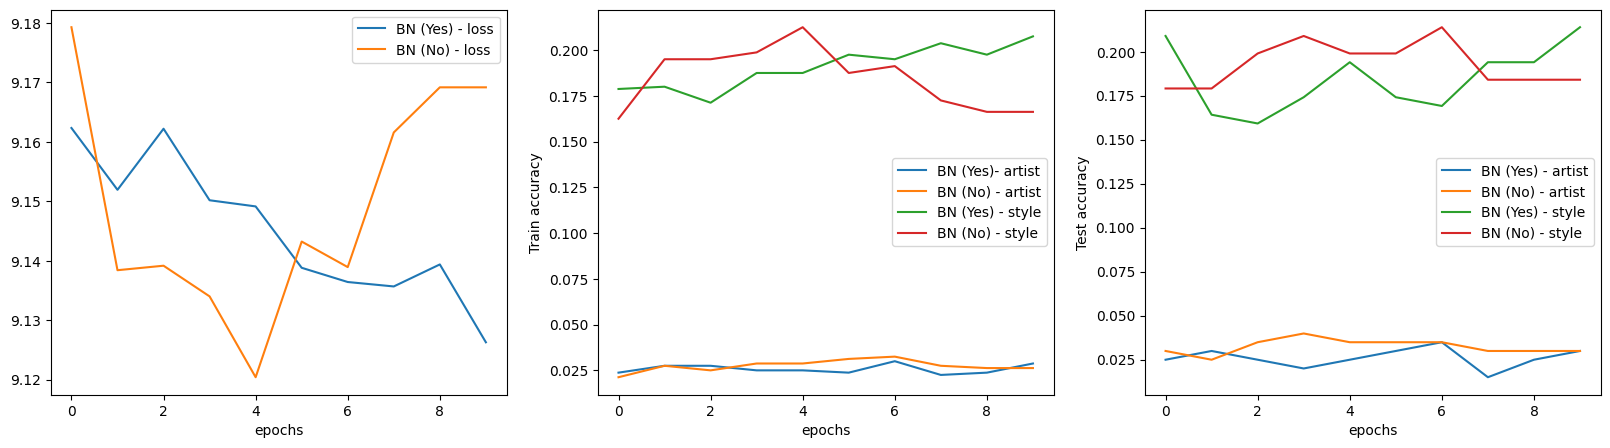

In [ ]:
fig, (ax11,ax21,ax31) = plt.subplots(1,3, figsize = (20,5))

## Plot cross entropy loss
ax11.plot(range(len(losses)), losses, label = 'BN (Yes) - loss', color = 'C0')
ax11.plot(range(len(losses_nobn)), losses_nobn, label = 'BN (No) - loss', color = 'C1')
ax11.set_xlabel('epochs')
ax11.legend()

## Plot train acc
ax21.plot(range(len(train_artist_acc)), train_artist_acc, label = 'BN (Yes)- artist', color = 'C0')
ax21.plot(range(len(train_artist_acc_nobn)), train_artist_acc_nobn, label = 'BN (No) - artist', color = 'C1')
ax21.plot(range(len(train_style_acc)), train_style_acc, label = 'BN (Yes) - style', color = 'C2')
ax21.plot(range(len(train_style_acc_nobn)), train_style_acc_nobn, label = 'BN (No) - style', color = 'C3')
ax21.set_ylabel('Train accuracy')
ax21.set_xlabel('epochs')
ax21.legend()

## Plot test acc
ax31.plot(range(len(test_artist_acc)), test_artist_acc, label = 'BN (Yes) - artist', color = 'C0')
ax31.plot(range(len(test_artist_acc_nobn)), test_artist_acc_nobn, label = 'BN (No) - artist', color = 'C1')
ax31.plot(range(len(test_style_acc)), test_style_acc, label = 'BN (Yes) - style', color = 'C2')
ax31.plot(range(len(test_style_acc_nobn)), test_style_acc_nobn, label = 'BN (No) - style', color = 'C3')
ax31.set_ylabel('Test accuracy')
ax31.set_xlabel('epochs')
ax31.legend()

### No Dropout (with ReLU)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiTaskResNet(
    num_authors=len(full_dataset.authors), 
    num_styles=len(full_dataset.styles),
    BATCHNORM = True, 
    ACTIVATION_FN = torch.relu, 
    DROPOUT = False, 
    DROPOUT_PROB = 0.3, 
    LINK_FN = torch.softmax, 
    loss_function = nn.CrossEntropyLoss(),
)

losses_nod, train_artist_acc_nod, test_artist_acc_nod, train_style_acc_nod, test_style_acc_nod = test_model(
    model=model,
    epochs=10,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device
)

Epoch 1/10 - Loss: 9.1605 - Train Acc Artist: 2.25% - Train Acc Style: 19.00%
Epoch 2/10 - Loss: 9.1360 - Train Acc Artist: 3.12% - Train Acc Style: 19.38%
Epoch 3/10 - Loss: 9.1533 - Train Acc Artist: 3.38% - Train Acc Style: 17.00%
Epoch 4/10 - Loss: 9.1619 - Train Acc Artist: 2.88% - Train Acc Style: 17.12%
Epoch 5/10 - Loss: 9.1701 - Train Acc Artist: 2.88% - Train Acc Style: 16.12%
Epoch 6/10 - Loss: 9.1678 - Train Acc Artist: 2.88% - Train Acc Style: 16.12%
Epoch 7/10 - Loss: 9.1759 - Train Acc Artist: 2.88% - Train Acc Style: 15.62%
Epoch 8/10 - Loss: 9.1663 - Train Acc Artist: 2.88% - Train Acc Style: 16.62%
Epoch 9/10 - Loss: 9.1642 - Train Acc Artist: 2.88% - Train Acc Style: 16.75%
Epoch 10/10 - Loss: 9.1476 - Train Acc Artist: 2.75% - Train Acc Style: 18.50%


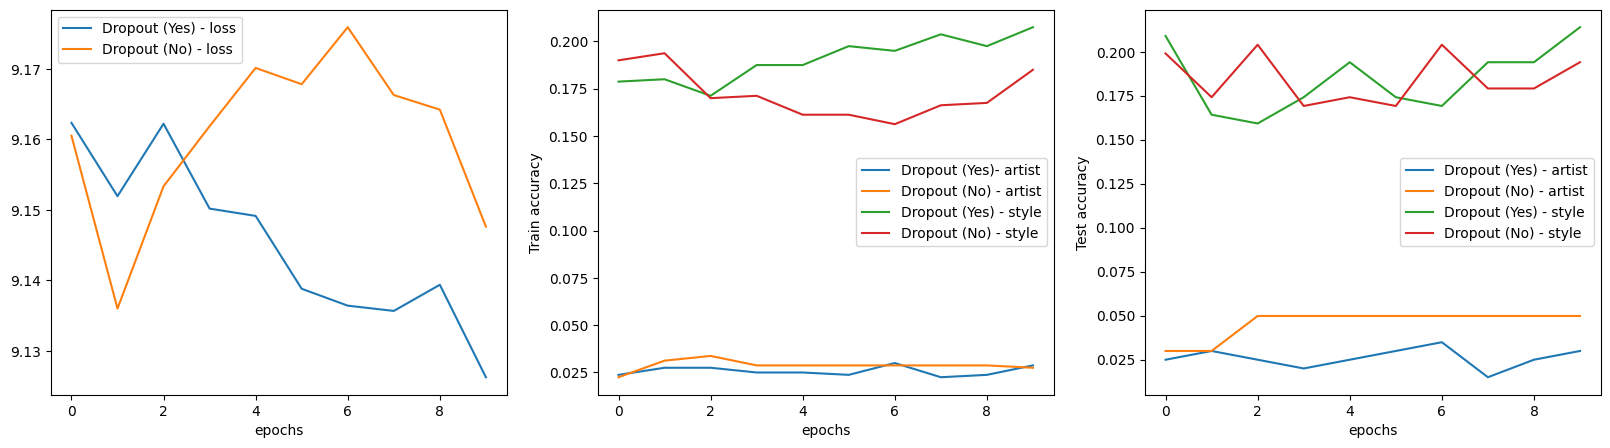

In [ ]:
fig, (ax11,ax21,ax31) = plt.subplots(1,3, figsize = (20,5))


## Plot cross entropy loss
ax11.plot(range(len(losses)), losses, label = 'Dropout (Yes) - loss', color = 'C0')
ax11.plot(range(len(losses_nod)), losses_nod, label = 'Dropout (No) - loss', color = 'C1')
ax11.set_xlabel('epochs')
ax11.legend()

## Plot train acc
ax21.plot(range(len(train_artist_acc)), train_artist_acc, label = 'Dropout (Yes)- artist', color = 'C0')
ax21.plot(range(len(train_artist_acc_nod)), train_artist_acc_nod, label = 'Dropout (No) - artist', color = 'C1')
ax21.plot(range(len(train_style_acc)), train_style_acc, label = 'Dropout (Yes) - style', color = 'C2')
ax21.plot(range(len(train_style_acc_nod)), train_style_acc_nod, label = 'Dropout (No) - style', color = 'C3')
ax21.set_ylabel('Train accuracy')
ax21.set_xlabel('epochs')
ax21.legend()

## Plot test acc
ax31.plot(range(len(test_artist_acc)), test_artist_acc, label = 'Dropout (Yes) - artist', color = 'C0')
ax31.plot(range(len(test_artist_acc_nod)), test_artist_acc_nod, label = 'Dropout (No) - artist', color = 'C1')
ax31.plot(range(len(test_style_acc)), test_style_acc, label = 'Dropout (Yes) - style', color = 'C2')
ax31.plot(range(len(test_style_acc_nod)), test_style_acc_nod, label = 'Dropout (No) - style', color = 'C3')
ax31.set_ylabel('Test accuracy')
ax31.set_xlabel('epochs')
ax31.legend()

### Modifiying dropout (with ReLU and dropout_prob=0.4 & dropout_prob=0.5)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiTaskResNet(
    num_authors=len(full_dataset.authors), 
    num_styles=len(full_dataset.styles),
    BATCHNORM = True, 
    ACTIVATION_FN = torch.relu, 
    DROPOUT = True, 
    DROPOUT_PROB = 0.4, 
    LINK_FN = torch.softmax, 
    loss_function = nn.CrossEntropyLoss(),
)

losses_04, train_artist_acc_04, test_artist_acc_04, train_style_acc_04, test_style_acc_04 = test_model(
    model=model,
    epochs=10,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device
)

Epoch 1/10 - Loss: 9.1800 - Train Acc Artist: 2.00% - Train Acc Style: 16.50%
Epoch 2/10 - Loss: 9.1512 - Train Acc Artist: 3.62% - Train Acc Style: 17.38%
Epoch 3/10 - Loss: 9.1626 - Train Acc Artist: 2.75% - Train Acc Style: 17.12%
Epoch 4/10 - Loss: 9.1592 - Train Acc Artist: 2.88% - Train Acc Style: 17.50%
Epoch 5/10 - Loss: 9.1586 - Train Acc Artist: 3.00% - Train Acc Style: 17.25%
Epoch 6/10 - Loss: 9.1655 - Train Acc Artist: 2.88% - Train Acc Style: 17.00%
Epoch 7/10 - Loss: 9.1758 - Train Acc Artist: 3.62% - Train Acc Style: 15.00%
Epoch 8/10 - Loss: 9.1940 - Train Acc Artist: 2.88% - Train Acc Style: 13.88%
Epoch 9/10 - Loss: 9.1744 - Train Acc Artist: 2.38% - Train Acc Style: 16.38%
Epoch 10/10 - Loss: 9.1751 - Train Acc Artist: 3.00% - Train Acc Style: 15.62%


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiTaskResNet(
    num_authors=len(full_dataset.authors), 
    num_styles=len(full_dataset.styles),
    BATCHNORM = True, 
    ACTIVATION_FN = torch.relu, 
    DROPOUT = True, 
    DROPOUT_PROB = 0.5, 
    LINK_FN = torch.softmax, 
    loss_function = nn.CrossEntropyLoss(),
)

losses_05, train_artist_acc_05, test_artist_acc_05, train_style_acc_05, test_style_acc_05 = test_model(
    model=model,
    epochs=10,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device
)

Epoch 1/10 - Loss: 9.1790 - Train Acc Artist: 2.12% - Train Acc Style: 17.00%
Epoch 2/10 - Loss: 9.1579 - Train Acc Artist: 3.12% - Train Acc Style: 17.50%
Epoch 3/10 - Loss: 9.1408 - Train Acc Artist: 2.62% - Train Acc Style: 19.75%
Epoch 4/10 - Loss: 9.1310 - Train Acc Artist: 2.75% - Train Acc Style: 20.50%
Epoch 5/10 - Loss: 9.1368 - Train Acc Artist: 2.75% - Train Acc Style: 19.50%
Epoch 6/10 - Loss: 9.1601 - Train Acc Artist: 2.25% - Train Acc Style: 17.75%
Epoch 7/10 - Loss: 9.1468 - Train Acc Artist: 2.50% - Train Acc Style: 19.12%
Epoch 8/10 - Loss: 9.1542 - Train Acc Artist: 2.88% - Train Acc Style: 18.00%
Epoch 9/10 - Loss: 9.1466 - Train Acc Artist: 2.88% - Train Acc Style: 18.75%
Epoch 10/10 - Loss: 9.1747 - Train Acc Artist: 3.12% - Train Acc Style: 15.75%


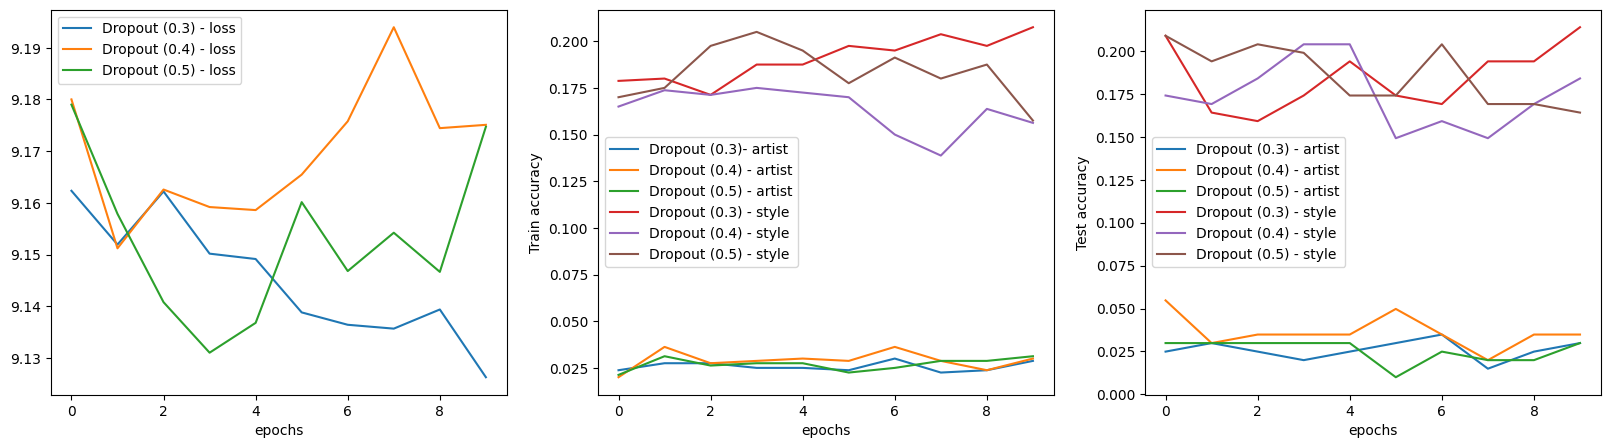

In [ ]:
fig, (ax11,ax21,ax31) = plt.subplots(1,3, figsize = (20,5))

## Plot cross entropy loss
ax11.plot(range(len(losses)), losses, label = 'Dropout (0.3) - loss', color = 'C0')
ax11.plot(range(len(losses_04)), losses_04, label = 'Dropout (0.4) - loss', color = 'C1')
ax11.plot(range(len(losses_05)), losses_05, label = 'Dropout (0.5) - loss', color = 'C2')
ax11.set_xlabel('epochs')
ax11.legend()

## Plot train acc
ax21.plot(range(len(train_artist_acc)), train_artist_acc, label = 'Dropout (0.3)- artist', color = 'C0')
ax21.plot(range(len(train_artist_acc_04)), train_artist_acc_04, label = 'Dropout (0.4) - artist', color = 'C1')
ax21.plot(range(len(train_artist_acc_05)), train_artist_acc_05, label = 'Dropout (0.5) - artist', color = 'C2')
ax21.plot(range(len(train_style_acc)), train_style_acc, label = 'Dropout (0.3) - style', color = 'C3')
ax21.plot(range(len(train_style_acc_04)), train_style_acc_04, label = 'Dropout (0.4) - style', color = 'C4')
ax21.plot(range(len(train_style_acc_05)), train_style_acc_05, label = 'Dropout (0.5) - style', color = 'C5')
ax21.set_ylabel('Train accuracy')
ax21.set_xlabel('epochs')
ax21.legend()

## Plot test acc
ax31.plot(range(len(test_artist_acc)), test_artist_acc, label = 'Dropout (0.3) - artist', color = 'C0')
ax31.plot(range(len(test_artist_acc_04)), test_artist_acc_04, label = 'Dropout (0.4) - artist', color = 'C1')
ax31.plot(range(len(test_artist_acc_05)), test_artist_acc_05, label = 'Dropout (0.5) - artist', color = 'C2')
ax31.plot(range(len(test_style_acc)), test_style_acc, label = 'Dropout (0.3) - style', color = 'C3')
ax31.plot(range(len(test_style_acc_04)), test_style_acc_04, label = 'Dropout (0.4) - style', color = 'C4')
ax31.plot(range(len(test_style_acc_05)), test_style_acc_05, label = 'Dropout (0.5) - style', color = 'C5')
ax31.set_ylabel('Test accuracy')
ax31.set_xlabel('epochs')
ax31.legend()

### Improving MultiTaskResNet 
* modifiying compute_loss
* adding scheduler
* dropout_prob=0.4
* removing softmax as link_function due to the loss_function (crossEntropyLoss()) has logsoftmax() in it.


In [ ]:
# Modelo multitarea configurable
class MultiTaskResNet_1(nn.Module):
    def __init__(self, num_authors, num_styles, BATCHNORM, ACTIVATION_FN, DROPOUT, DROPOUT_PROB, loss_function):
        super(MultiTaskResNet_1, self).__init__()
        
        self.loss_FN = loss_function
        self.link_FN = lambda x, dim: x
        self.activation_FN = ACTIVATION_FN
        self.batchNorm = BATCHNORM
        self.dropout = DROPOUT
        self.dropout_prob = DROPOUT_PROB
        
        base_model = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.features = nn.Sequential(*list(base_model.children())[:-1])
        in_features = base_model.fc.in_features

        layers = [nn.Flatten()]
        if self.batchNorm:
            layers.append(nn.BatchNorm1d(in_features))
        
        layers.append(nn.Linear(in_features, in_features))
        layers.append(self.wrap_activation(self.activation_FN))
        
        if self.dropout:
            layers.append(nn.Dropout(self.dropout_prob))
        
        layers.append(nn.Linear(in_features, in_features))
        layers.append(self.wrap_activation(self.activation_FN))
        
        self.shared_head = nn.Sequential(*layers)
        self.fc_artist = nn.Linear(in_features, num_authors)
        self.fc_style = nn.Linear(in_features, num_styles)

    def wrap_activation(self, ACTIVATION_FN):
        if ACTIVATION_FN == torch.relu:
            return nn.ReLU()
        elif ACTIVATION_FN == torch.tanh:
            return nn.Tanh()
        else:
            raise ValueError("Función de activación no soportada. Usa torch.relu o torch.tanh.")


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.shared_head(x)
        artist_output = self.link_FN(self.fc_artist(x), dim=1)
        style_output = self.link_FN(self.fc_style(x), dim=1)
        return artist_output, style_output
    
    def compute_loss(self, artist_logits, artist_targets, style_logits, style_targets):
        # ponderación opcional si una tarea es más difícil que otra
        return 0.6 * self.loss_FN(artist_logits, artist_targets) + 0.4 * self.loss_FN(style_logits, style_targets)
    
def test_model(model, epochs, train_loader, test_loader, device):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    
    train_loss_list, train_acc_artist_list, test_acc_artist_list = [], [], []
    train_acc_style_list, test_acc_style_list = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_artist, correct_style, total = 0, 0, 0

        for images, artist_labels, style_labels in train_loader:
            images, artist_labels, style_labels = images.to(device), artist_labels.to(device), style_labels.to(device)
            optimizer.zero_grad()
            artist_logits, style_logits = model(images)
            loss = model.compute_loss(artist_logits, artist_labels, style_logits, style_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            with torch.no_grad():
                artist_preds = torch.argmax(artist_logits, dim=1)
                style_preds = torch.argmax(style_logits, dim=1)
                correct_artist += (artist_preds == artist_labels).sum().item()
                correct_style += (style_preds == style_labels).sum().item()
                total += images.size(0)

        #Scheduling learning rate
        scheduler.step()
        
        train_loss_list.append(total_loss / len(train_loader))
        train_acc_artist_list.append(correct_artist / total)
        train_acc_style_list.append(correct_style / total)

        # Evaluación en test
        model.eval()
        correct_artist_test, correct_style_test, total_test = 0, 0, 0
        with torch.no_grad():
            for images, artist_labels, style_labels in test_loader:
                images, artist_labels, style_labels = images.to(device), artist_labels.to(device), style_labels.to(device)
                artist_logits, style_logits = model(images)
                artist_preds = torch.argmax(artist_logits, dim=1)
                style_preds = torch.argmax(style_logits, dim=1)
                correct_artist_test += (artist_preds == artist_labels).sum().item()
                correct_style_test += (style_preds == style_labels).sum().item()
                total_test += images.size(0)

        test_acc_artist_list.append(correct_artist_test / total_test)
        test_acc_style_list.append(correct_style_test / total_test)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_loader):.4f} - Train Acc Artist: {correct_artist / total:.2%} - Train Acc Style: {correct_style / total:.2%}")

    return train_loss_list, train_acc_artist_list, test_acc_artist_list, train_acc_style_list, test_acc_style_list

    

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiTaskResNet_1(
    num_authors=len(full_dataset.authors), 
    num_styles=len(full_dataset.styles),
    BATCHNORM = True, 
    ACTIVATION_FN = torch.relu, 
    DROPOUT = True, 
    DROPOUT_PROB = 0.4,  
    loss_function = nn.CrossEntropyLoss(),
)

losses_1, train_artist_acc_1, test_artist_acc_1, train_style_acc_1, test_style_acc_1 = test_model(
    model=model,
    epochs=10,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device
)

Epoch 1/10 - Loss: 4.7295 - Train Acc Artist: 2.50% - Train Acc Style: 18.12%
Epoch 2/10 - Loss: 4.4271 - Train Acc Artist: 4.88% - Train Acc Style: 20.00%
Epoch 3/10 - Loss: 4.3320 - Train Acc Artist: 4.25% - Train Acc Style: 18.75%
Epoch 4/10 - Loss: 4.1533 - Train Acc Artist: 6.38% - Train Acc Style: 21.12%
Epoch 5/10 - Loss: 4.0293 - Train Acc Artist: 6.75% - Train Acc Style: 20.88%
Epoch 6/10 - Loss: 3.8985 - Train Acc Artist: 6.62% - Train Acc Style: 21.88%
Epoch 7/10 - Loss: 3.7803 - Train Acc Artist: 7.12% - Train Acc Style: 24.00%
Epoch 8/10 - Loss: 3.6247 - Train Acc Artist: 8.50% - Train Acc Style: 22.62%
Epoch 9/10 - Loss: 3.5618 - Train Acc Artist: 9.12% - Train Acc Style: 26.00%
Epoch 10/10 - Loss: 3.3856 - Train Acc Artist: 10.12% - Train Acc Style: 28.00%


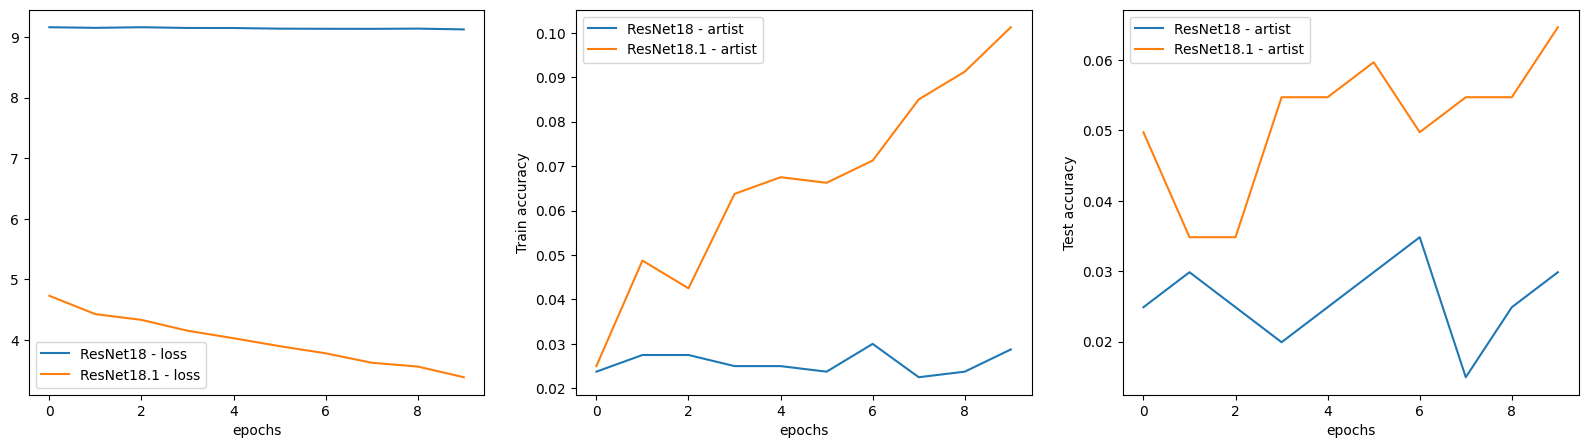

In [ ]:
fig, (ax11,ax21,ax31) = plt.subplots(1,3, figsize = (20,5))


## Plot cross entropy loss
ax11.plot(range(len(losses)), losses, label = 'ResNet18 - loss', color = 'C0')
ax11.plot(range(len(losses_1)), losses_1, label = 'ResNet18.1 - loss', color = 'C1')
ax11.set_xlabel('epochs')
ax11.legend()

## Plot train acc
ax21.plot(range(len(train_artist_acc)), train_artist_acc, label = 'ResNet18 - artist', color = 'C0')
ax21.plot(range(len(train_artist_acc_1)), train_artist_acc_1, label = 'ResNet18.1 - artist', color = 'C1')
ax21.set_ylabel('Train accuracy')
ax21.set_xlabel('epochs')
ax21.legend()

## Plot test acc
ax31.plot(range(len(test_artist_acc)), test_artist_acc, label = 'ResNet18 - artist', color = 'C0')
ax31.plot(range(len(test_artist_acc_1)), test_artist_acc_1, label = 'ResNet18.1 - artist', color = 'C1')
ax31.set_ylabel('Test accuracy')
ax31.set_xlabel('epochs')
ax31.legend()

### Improving MultiTaskResNet (by using ResNet34)

In [ ]:
from torchvision.models import resnet34, ResNet34_Weights

In [ ]:
# Modelo multitarea configurable
class MultiTaskResNet34(nn.Module):
    def __init__(self, num_authors, num_styles, BATCHNORM, ACTIVATION_FN, DROPOUT, DROPOUT_PROB, loss_function):
        super(MultiTaskResNet34, self).__init__()
        
        self.loss_FN = loss_function
        self.link_FN = lambda x, dim: x
        self.activation_FN = ACTIVATION_FN
        self.batchNorm = BATCHNORM
        self.dropout = DROPOUT
        self.dropout_prob = DROPOUT_PROB
        
        base_model = resnet34(weights=ResNet34_Weights.DEFAULT)
        self.features = nn.Sequential(*list(base_model.children())[:-1])
        in_features = base_model.fc.in_features

        layers = [nn.Flatten()]
        if self.batchNorm:
            layers.append(nn.BatchNorm1d(in_features))
            
        layers += [
            nn.Linear(in_features, 512),
            self.wrap_activation(self.activation_FN),
        ]
                
        if self.dropout:
            layers.append(nn.Dropout(self.dropout_prob))
        
        layers += [
            nn.Linear(512, 256),
            self.wrap_activation(self.activation_FN),
        ]
        
        if self.dropout:
            layers.append(nn.Dropout(self.dropout_prob))
        
        layers += [
            nn.Linear(256, in_features),
            self.wrap_activation(self.activation_FN),
        ]
        
        self.shared_head = nn.Sequential(*layers)
        self.fc_artist = nn.Linear(in_features, num_authors)
        self.fc_style = nn.Linear(in_features, num_styles)

    def wrap_activation(self, ACTIVATION_FN):
        if ACTIVATION_FN == torch.relu:
            return nn.ReLU()
        elif ACTIVATION_FN == torch.tanh:
            return nn.Tanh()
        else:
            raise ValueError("Función de activación no soportada. Usa torch.relu o torch.tanh.")


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.shared_head(x)
        artist_output = self.link_FN(self.fc_artist(x), dim=1)
        style_output = self.link_FN(self.fc_style(x), dim=1)
        return artist_output, style_output
    
    def compute_loss(self, artist_logits, artist_targets, style_logits, style_targets):
        # ponderación opcional si una tarea es más difícil que otra
        return 0.6 * self.loss_FN(artist_logits, artist_targets) + 0.4 * self.loss_FN(style_logits, style_targets)
    
def test_model(model, epochs, train_loader, test_loader, device):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    
    train_loss_list, train_acc_artist_list, test_acc_artist_list = [], [], []
    train_acc_style_list, test_acc_style_list = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_artist, correct_style, total = 0, 0, 0

        for images, artist_labels, style_labels in train_loader:
            images, artist_labels, style_labels = images.to(device), artist_labels.to(device), style_labels.to(device)
            optimizer.zero_grad()
            artist_logits, style_logits = model(images)
            loss = model.compute_loss(artist_logits, artist_labels, style_logits, style_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            with torch.no_grad():
                artist_preds = torch.argmax(artist_logits, dim=1)
                style_preds = torch.argmax(style_logits, dim=1)
                correct_artist += (artist_preds == artist_labels).sum().item()
                correct_style += (style_preds == style_labels).sum().item()
                total += images.size(0)

        #Scheduling learning rate
        scheduler.step()
        
        train_loss_list.append(total_loss / len(train_loader))
        train_acc_artist_list.append(correct_artist / total)
        train_acc_style_list.append(correct_style / total)

        # Evaluación en test
        model.eval()
        correct_artist_test, correct_style_test, total_test = 0, 0, 0
        with torch.no_grad():
            for images, artist_labels, style_labels in test_loader:
                images, artist_labels, style_labels = images.to(device), artist_labels.to(device), style_labels.to(device)
                artist_logits, style_logits = model(images)
                artist_preds = torch.argmax(artist_logits, dim=1)
                style_preds = torch.argmax(style_logits, dim=1)
                correct_artist_test += (artist_preds == artist_labels).sum().item()
                correct_style_test += (style_preds == style_labels).sum().item()
                total_test += images.size(0)

        test_acc_artist_list.append(correct_artist_test / total_test)
        test_acc_style_list.append(correct_style_test / total_test)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_loader):.4f} - Train Acc Artist: {correct_artist / total:.2%} - Train Acc Style: {correct_style / total:.2%}")

    return train_loss_list, train_acc_artist_list, test_acc_artist_list, train_acc_style_list, test_acc_style_list

    

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiTaskResNet34(
    num_authors=len(full_dataset.authors), 
    num_styles=len(full_dataset.styles),
    BATCHNORM = True, 
    ACTIVATION_FN = torch.relu, 
    DROPOUT = True, 
    DROPOUT_PROB = 0.4,  
    loss_function = nn.CrossEntropyLoss(),
)

losses_36, train_artist_acc_36, test_artist_acc_36, train_style_acc_36, test_style_acc_36 = test_model(
    model=model,
    epochs=10,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device
)

Epoch 1/10 - Loss: 4.7529 - Train Acc Artist: 2.50% - Train Acc Style: 15.75%
Epoch 2/10 - Loss: 4.5141 - Train Acc Artist: 2.50% - Train Acc Style: 16.38%
Epoch 3/10 - Loss: 4.4904 - Train Acc Artist: 2.62% - Train Acc Style: 18.25%
Epoch 4/10 - Loss: 4.4469 - Train Acc Artist: 2.38% - Train Acc Style: 19.00%
Epoch 5/10 - Loss: 4.3719 - Train Acc Artist: 2.50% - Train Acc Style: 19.25%
Epoch 6/10 - Loss: 4.3206 - Train Acc Artist: 3.25% - Train Acc Style: 20.00%
Epoch 7/10 - Loss: 4.2873 - Train Acc Artist: 4.00% - Train Acc Style: 19.25%
Epoch 8/10 - Loss: 4.2402 - Train Acc Artist: 4.12% - Train Acc Style: 19.12%
Epoch 9/10 - Loss: 4.1877 - Train Acc Artist: 3.25% - Train Acc Style: 18.62%
Epoch 10/10 - Loss: 4.1871 - Train Acc Artist: 3.88% - Train Acc Style: 20.38%


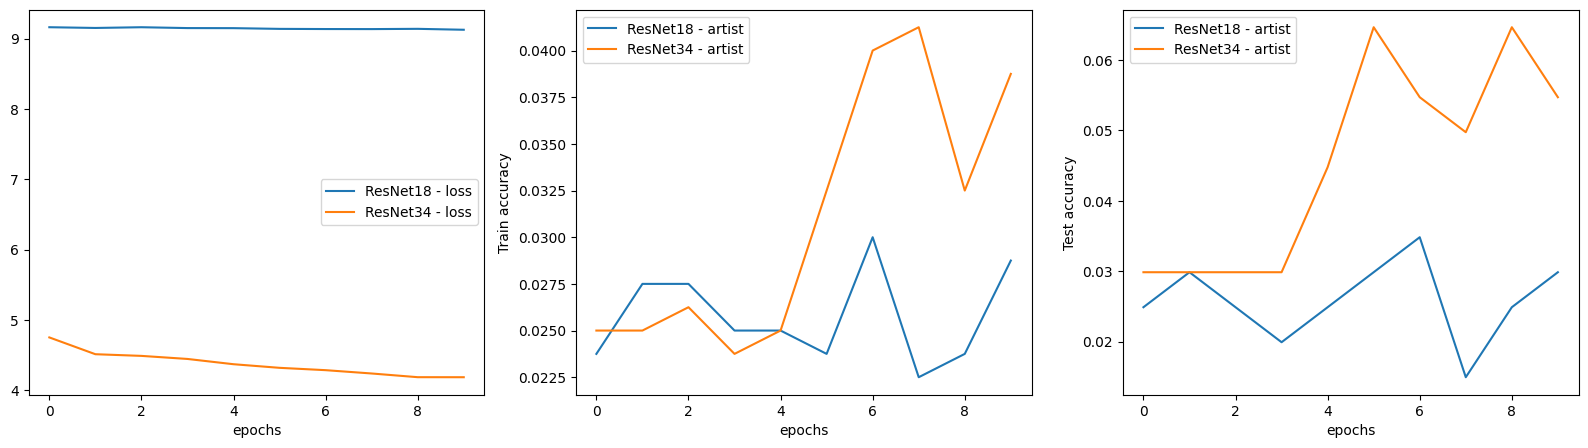

In [ ]:
fig, (ax11,ax21,ax31) = plt.subplots(1,3, figsize = (20,5))

## Plot cross entropy loss
ax11.plot(range(len(losses)), losses, label = 'ResNet18 - loss', color = 'C0')
ax11.plot(range(len(losses_36)), losses_36, label = 'ResNet34 - loss', color = 'C1')
ax11.set_xlabel('epochs')
ax11.legend()

## Plot train acc
ax21.plot(range(len(train_artist_acc)), train_artist_acc, label = 'ResNet18 - artist', color = 'C0')
ax21.plot(range(len(train_artist_acc_36)), train_artist_acc_36, label = 'ResNet34 - artist', color = 'C1')
ax21.set_ylabel('Train accuracy')
ax21.set_xlabel('epochs')
ax21.legend()

## Plot test acc
ax31.plot(range(len(test_artist_acc)), test_artist_acc, label = 'ResNet18 - artist', color = 'C0')
ax31.plot(range(len(test_artist_acc_36)), test_artist_acc_36, label = 'ResNet34 - artist', color = 'C1')
ax31.set_ylabel('Test accuracy')
ax31.set_xlabel('epochs')
ax31.legend()

### Improving ResNet34 
* Modifiying dropout_prob (dropout_prob=0.2), resize (224x224), compute_loss (70% loss-artist and 30% loss-style)
* Grouping artists with fewer than 10 pictures
* Applying argumentations in transformers (rotation, flip, colorjitter)
* Balanced classes (with WeightedRandomSampler()): calculating inverse weights, balanced sampling in training with inverse weights.
* Adding task-specific heads (self.artist_head & self.style_head)
* Modifiying scheduler ("ReduceLROnPlateau") para ajustar el learning rate
* Adding epochs (epochs = 20)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset, WeightedRandomSampler
from torchvision import transforms
from torchvision.models import resnet34, ResNet34_Weights
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
# Transformaciones
transform_ = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Dataset personalizado
class ArtDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.authors = sorted(self.data['artist'].unique())
        self.styles = sorted(self.data['style'].unique())
        self.author_to_idx = {author: idx for idx, author in enumerate(self.authors)}
        self.style_to_idx = {style: idx for idx, style in enumerate(self.styles)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['path'].replace('\\', '/')
        full_path = os.path.join(self.img_dir, os.path.basename(img_path))
        image = Image.open(full_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        author = self.author_to_idx[self.data.iloc[idx]['artist']]
        style = self.style_to_idx[self.data.iloc[idx]['style']]
        return image, author, style

# Modelo multitarea configurable
class MultiTaskResNet_m(nn.Module):
    def __init__(self, num_authors, num_styles, BATCHNORM, ACTIVATION_FN, DROPOUT, DROPOUT_PROB, loss_function):
        super(MultiTaskResNet_m, self).__init__()
        
        self.loss_FN = loss_function
        self.link_FN = lambda x, dim: x
        self.activation_FN = ACTIVATION_FN
        self.batchNorm = BATCHNORM
        self.dropout = DROPOUT
        self.dropout_prob = DROPOUT_PROB
        
        base_model = resnet34(weights=ResNet34_Weights.DEFAULT)
        self.features = nn.Sequential(*list(base_model.children())[:-1])
        in_features = base_model.fc.in_features

        layers = [nn.Flatten()]
        if self.batchNorm:
            layers.append(nn.BatchNorm1d(in_features))
        
        layers.append(nn.Linear(in_features, in_features))
        layers.append(self.wrap_activation(self.activation_FN))
        
        if self.dropout:
            layers.append(nn.Dropout(self.dropout_prob))
        
        layers.append(nn.Linear(in_features, in_features))
        layers.append(self.wrap_activation(self.activation_FN))
        
        self.shared_head = nn.Sequential(*layers)
        self.fc_artist = nn.Linear(in_features, num_authors)
        self.artist_head = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.ReLU(),
            nn.Dropout(self.dropout_prob)
        )
        self.style_head = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.ReLU(),
            nn.Dropout(self.dropout_prob)
        )
        self.fc_style = nn.Linear(in_features, num_styles)

    def wrap_activation(self, ACTIVATION_FN):
        if ACTIVATION_FN == torch.relu:
            return nn.ReLU()
        elif ACTIVATION_FN == torch.tanh:
            return nn.Tanh()
        else:
            raise ValueError("Función de activación no soportada. Usa torch.relu o torch.tanh.")


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.shared_head(x)
        
        artist_output = self.link_FN(self.fc_artist(self.artist_head(x)), dim=1)
        style_output = self.link_FN(self.fc_style(self.style_head(x)), dim=1)
        
        return artist_output, style_output
    
    def compute_loss(self, artist_logits, artist_targets, style_logits, style_targets):
        # ponderación opcional si una tarea es más difícil que otra
        return 0.7 * self.loss_FN(artist_logits, artist_targets) + 0.3 * self.loss_FN(style_logits, style_targets)
    
def test_model(model, epochs, train_loader, test_loader, device):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
    
    train_loss_list, train_acc_artist_list, test_acc_artist_list = [], [], []
    train_acc_style_list, test_acc_style_list = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_artist, correct_style, total = 0, 0, 0

        for images, artist_labels, style_labels in train_loader:
            images, artist_labels, style_labels = images.to(device), artist_labels.to(device), style_labels.to(device)
            optimizer.zero_grad()
            artist_logits, style_logits = model(images)
            loss = model.compute_loss(artist_logits, artist_labels, style_logits, style_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            with torch.no_grad():
                artist_preds = torch.argmax(artist_logits, dim=1)
                style_preds = torch.argmax(style_logits, dim=1)
                correct_artist += (artist_preds == artist_labels).sum().item()
                correct_style += (style_preds == style_labels).sum().item()
                total += images.size(0)

               
        train_loss_list.append(total_loss / len(train_loader))
        train_acc_artist_list.append(correct_artist / total)
        train_acc_style_list.append(correct_style / total)

        # Evaluación en test
        model.eval()
        correct_artist_test, correct_style_test, total_test = 0, 0, 0
        with torch.no_grad():
            for images, artist_labels, style_labels in test_loader:
                images, artist_labels, style_labels = images.to(device), artist_labels.to(device), style_labels.to(device)
                artist_logits, style_logits = model(images)
                artist_preds = torch.argmax(artist_logits, dim=1)
                style_preds = torch.argmax(style_logits, dim=1)
                correct_artist_test += (artist_preds == artist_labels).sum().item()
                correct_style_test += (style_preds == style_labels).sum().item()
                total_test += images.size(0)
        
        test_acc_artist_list.append(correct_artist_test / total_test)
        test_acc_style_list.append(correct_style_test / total_test)

        scheduler.step(correct_artist_test/total_test)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_loader):.4f} - Train Acc Artist: {correct_artist / total:.2%} - Train Acc Style: {correct_style / total:.2%}")

    return train_loss_list, train_acc_artist_list, test_acc_artist_list, train_acc_style_list, test_acc_style_list

    

In [ ]:
# Preparar datos
script_dir = os.path.dirname(os.path.abspath("1001_images"))
img_dir = os.path.join(script_dir, "1001_images")
csv_path = "https://raw.githubusercontent.com/jsantonjag/PaintingsAI/refs/heads/main/data/dataset_completo.csv"
df = pd.read_csv(csv_path)

#Agrupar artistas con <10 imágenes como "Otros"
artist_counts = df['artist'].value_counts()
valid_artists = artist_counts[artist_counts >= 10].index.tolist()
df['artist'] = df['artist'].apply(lambda x: x if x in valid_artists else 'Otros')

df.to_csv("filtered_dataset.csv", index=False)

df['path'] = df['path'].apply(lambda x: os.path.join(img_dir, x))

full_dataset = ArtDataset(csv_file="filtered_dataset.csv", img_dir=img_dir, transform=transform_)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Calcular pesos inversos por clase
author_labels = [sample[1] for sample in train_dataset]
class_sample_counts = pd.Series(author_labels).value_counts().sort_index()
weights = 1. / class_sample_counts
sample_weights = [weights[label] for label in author_labels]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=16)


In [ ]:
#Entrenamiento con la ReLU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiTaskResNet_m(
    num_authors=len(full_dataset.authors), 
    num_styles=len(full_dataset.styles),
    BATCHNORM = True, 
    ACTIVATION_FN = torch.relu, 
    DROPOUT = True, 
    DROPOUT_PROB = 0.2,  
    loss_function = nn.CrossEntropyLoss(),
)

losses_n, train_artist_acc_n, test_artist_acc_n, train_style_acc_n, test_style_acc_n = test_model(
    model=model,
    epochs=20,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device
)

Epoch 1/20 - Loss: 2.3614 - Train Acc Artist: 16.50% - Train Acc Style: 35.62%
Epoch 2/20 - Loss: 2.2387 - Train Acc Artist: 19.00% - Train Acc Style: 41.00%
Epoch 3/20 - Loss: 2.1559 - Train Acc Artist: 23.62% - Train Acc Style: 40.00%
Epoch 4/20 - Loss: 2.0498 - Train Acc Artist: 27.00% - Train Acc Style: 44.75%
Epoch 5/20 - Loss: 1.9839 - Train Acc Artist: 28.62% - Train Acc Style: 45.38%
Epoch 6/20 - Loss: 1.8643 - Train Acc Artist: 35.75% - Train Acc Style: 46.38%
Epoch 7/20 - Loss: 1.9466 - Train Acc Artist: 31.75% - Train Acc Style: 46.50%
Epoch 8/20 - Loss: 1.8359 - Train Acc Artist: 36.12% - Train Acc Style: 49.38%
Epoch 9/20 - Loss: 1.6553 - Train Acc Artist: 42.88% - Train Acc Style: 54.00%
Epoch 10/20 - Loss: 1.6180 - Train Acc Artist: 44.12% - Train Acc Style: 56.50%
Epoch 11/20 - Loss: 1.6148 - Train Acc Artist: 42.88% - Train Acc Style: 52.00%
Epoch 12/20 - Loss: 1.5920 - Train Acc Artist: 40.88% - Train Acc Style: 56.00%
Epoch 13/20 - Loss: 1.3532 - Train Acc Artist: 53

NameError: name 'losses_n' is not defined

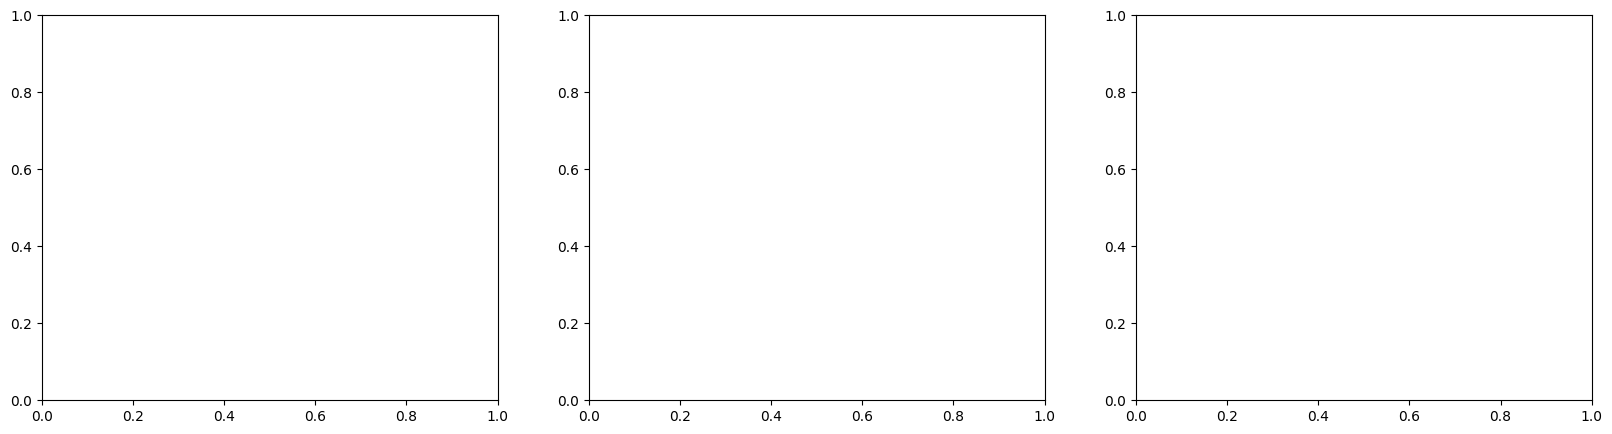

In [ ]:
import matplotlib.pyplot as plt

fig, (ax11,ax21,ax31) = plt.subplots(1,3, figsize = (20,5))

## Plot cross entropy loss
#ax11.plot(range(len(losses)), losses, label = 'ResNet18 - loss', color = 'C0')
ax11.plot(range(len(losses_n)), losses_n, label = 'ResNet34 new - loss', color = 'C1')
ax11.set_xlabel('epochs')
ax11.legend()

## Plot train acc
#ax21.plot(range(len(train_artist_acc)), train_artist_acc, label = 'ResNet18 - artist', color = 'C0')
ax21.plot(range(len(train_artist_acc_n)), train_artist_acc_n, label = 'ResNet34 new - artist', color = 'C1')
ax21.set_ylabel('Train accuracy')
ax21.set_xlabel('epochs')
ax21.legend()

## Plot test acc
#ax31.plot(range(len(test_artist_acc)), test_artist_acc, label = 'ResNet18 - artist', color = 'C0')
ax31.plot(range(len(test_artist_acc_n)), test_artist_acc_n, label = 'ResNet34 new - artist', color = 'C1')
ax31.set_ylabel('Test accuracy')
ax31.set_xlabel('epochs')
ax31.legend()